In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 150 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-4
LEARNING_RATE = .00005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 150 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


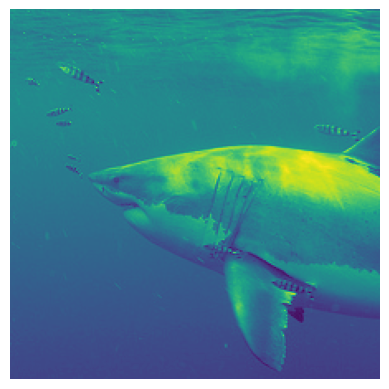

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000050, Loss: 1.0818


Epoch 1, Batch 2, LR: 0.000050, Loss: 1.0297


Epoch 1, Batch 3, LR: 0.000050, Loss: 0.8551


Epoch 1, Batch 4, LR: 0.000050, Loss: 0.8103


Epoch 1, Batch 5, LR: 0.000050, Loss: 0.7602


Epoch 1, Batch 6, LR: 0.000050, Loss: 0.7369


Epoch 1, Batch 7, LR: 0.000050, Loss: 0.6822


Epoch 1, Batch 8, LR: 0.000050, Loss: 0.6713


Epoch 1, Batch 9, LR: 0.000050, Loss: 0.6560


Epoch 1, Batch 10, LR: 0.000049, Loss: 0.6655


Epoch 1, Batch 11, LR: 0.000049, Loss: 0.6656


Epoch 1, Batch 12, LR: 0.000049, Loss: 0.6404


Epoch 1, Batch 13, LR: 0.000049, Loss: 0.6354


Epoch 1, Batch 14, LR: 0.000049, Loss: 0.6317


Epoch 1, Batch 15, LR: 0.000049, Loss: 0.6626


Epoch 1, Batch 16, LR: 0.000049, Loss: 0.6091


Epoch 1, Batch 17, LR: 0.000048, Loss: 0.6377


Epoch 1, Batch 18, LR: 0.000048, Loss: 0.6400


Epoch 1, Batch 19, LR: 0.000048, Loss: 0.6256


Epoch 1, Batch 20, LR: 0.000048, Loss: 0.6077


Epoch 1, Batch 21, LR: 0.000048, Loss: 0.6017


Epoch 1, Batch 22, LR: 0.000047, Loss: 0.6102


Epoch 1, Batch 23, LR: 0.000047, Loss: 0.5758


Epoch 1, Batch 24, LR: 0.000047, Loss: 0.5908


Epoch 1, Batch 25, LR: 0.000047, Loss: 0.6109


Epoch 1, Batch 26, LR: 0.000046, Loss: 0.6066


Epoch 1, Batch 27, LR: 0.000046, Loss: 0.6175


Epoch 1, Batch 28, LR: 0.000046, Loss: 0.5822


Epoch 1, Batch 29, LR: 0.000046, Loss: 0.6274


Epoch 1, Batch 30, LR: 0.000045, Loss: 0.6092


Epoch 1, Batch 31, LR: 0.000045, Loss: 0.5872


Epoch 1, Batch 32, LR: 0.000045, Loss: 0.5853


Epoch 1, Batch 33, LR: 0.000044, Loss: 0.5733


Epoch 1, Batch 34, LR: 0.000044, Loss: 0.6231


Epoch 1, Batch 35, LR: 0.000044, Loss: 0.5992


Epoch 1, Batch 36, LR: 0.000043, Loss: 0.5924


Epoch 1, Batch 37, LR: 0.000043, Loss: 0.6112


Epoch 1, Batch 38, LR: 0.000042, Loss: 0.5782


Epoch 1, Batch 39, LR: 0.000042, Loss: 0.6269


Epoch 1, Batch 40, LR: 0.000042, Loss: 0.5810


Epoch 1, Batch 41, LR: 0.000041, Loss: 0.5977


Epoch 1, Batch 42, LR: 0.000041, Loss: 0.6053


Epoch 1, Batch 43, LR: 0.000041, Loss: 0.5980


Epoch 1, Batch 44, LR: 0.000040, Loss: 0.5804


Epoch 1, Batch 45, LR: 0.000040, Loss: 0.5871


Epoch 1, Batch 46, LR: 0.000039, Loss: 0.5972


Epoch 1, Batch 47, LR: 0.000039, Loss: 0.5834


Epoch 1, Batch 48, LR: 0.000038, Loss: 0.5939


Epoch 1, Batch 49, LR: 0.000038, Loss: 0.5804


Epoch 1, Batch 50, LR: 0.000037, Loss: 0.5836


Epoch 1, Batch 51, LR: 0.000037, Loss: 0.5761


Epoch 1, Batch 52, LR: 0.000037, Loss: 0.5871


Epoch 1, Batch 53, LR: 0.000036, Loss: 0.6079


Epoch 1, Batch 54, LR: 0.000036, Loss: 0.5939


Epoch 1, Batch 55, LR: 0.000035, Loss: 0.6100


Epoch 1, Batch 56, LR: 0.000035, Loss: 0.5661


Epoch 1, Batch 57, LR: 0.000034, Loss: 0.6017


Epoch 1, Batch 58, LR: 0.000034, Loss: 0.5834


Epoch 1, Batch 59, LR: 0.000033, Loss: 0.5710


Epoch 1, Batch 60, LR: 0.000033, Loss: 0.5868


Epoch 1, Batch 61, LR: 0.000032, Loss: 0.5717


Epoch 1, Batch 62, LR: 0.000032, Loss: 0.5865


Epoch 1, Batch 63, LR: 0.000031, Loss: 0.6019


Epoch 1, Batch 64, LR: 0.000031, Loss: 0.5745


Epoch 1, Batch 65, LR: 0.000030, Loss: 0.5871


Epoch 1, Batch 66, LR: 0.000030, Loss: 0.6014


Epoch 1, Batch 67, LR: 0.000029, Loss: 0.5685


Epoch 1, Batch 68, LR: 0.000029, Loss: 0.5746


Epoch 1, Batch 69, LR: 0.000028, Loss: 0.6028


Epoch 1, Batch 70, LR: 0.000028, Loss: 0.5881


Epoch 1, Batch 71, LR: 0.000027, Loss: 0.5788


Epoch 1, Batch 72, LR: 0.000027, Loss: 0.5826


Epoch 1, Batch 73, LR: 0.000026, Loss: 0.5754


Epoch 1, Batch 74, LR: 0.000026, Loss: 0.5769


Epoch 1, Batch 75, LR: 0.000025, Loss: 0.5573


Epoch 1, Batch 76, LR: 0.000024, Loss: 0.5885


Epoch 1, Batch 77, LR: 0.000024, Loss: 0.5880


Epoch 1, Batch 78, LR: 0.000023, Loss: 0.5926


Epoch 1, Batch 79, LR: 0.000023, Loss: 0.6087


Epoch 1, Batch 80, LR: 0.000022, Loss: 0.5874


Epoch 1, Batch 81, LR: 0.000022, Loss: 0.5608


Epoch 1, Batch 82, LR: 0.000021, Loss: 0.5629


Epoch 1, Batch 83, LR: 0.000021, Loss: 0.5938


Epoch 1, Batch 84, LR: 0.000020, Loss: 0.5947


Epoch 1, Batch 85, LR: 0.000020, Loss: 0.5859


Epoch 1, Batch 86, LR: 0.000019, Loss: 0.5572


Epoch 1, Batch 87, LR: 0.000019, Loss: 0.5673


Epoch 1, Batch 88, LR: 0.000018, Loss: 0.5970


Epoch 1, Batch 89, LR: 0.000018, Loss: 0.5819


Epoch 1, Batch 90, LR: 0.000017, Loss: 0.5722


Epoch 1, Batch 91, LR: 0.000017, Loss: 0.5643


Epoch 1, Batch 92, LR: 0.000016, Loss: 0.5830


Epoch 1, Batch 93, LR: 0.000016, Loss: 0.5824


Epoch 1, Batch 94, LR: 0.000015, Loss: 0.5844


Epoch 1, Batch 95, LR: 0.000015, Loss: 0.5723


Epoch 1, Batch 96, LR: 0.000014, Loss: 0.5815


Epoch 1, Batch 97, LR: 0.000014, Loss: 0.5721


Epoch 1, Batch 98, LR: 0.000013, Loss: 0.5857


Epoch 1, Batch 99, LR: 0.000013, Loss: 0.5747


Epoch 1, Batch 100, LR: 0.000012, Loss: 0.5805


Epoch 1, Batch 101, LR: 0.000012, Loss: 0.5605


Epoch 1, Batch 102, LR: 0.000012, Loss: 0.5813


Epoch 1, Batch 103, LR: 0.000011, Loss: 0.5652


Epoch 1, Batch 104, LR: 0.000011, Loss: 0.5713


Epoch 1, Batch 105, LR: 0.000010, Loss: 0.5935


Epoch 1, Batch 106, LR: 0.000010, Loss: 0.5828


Epoch 1, Batch 107, LR: 0.000009, Loss: 0.6003


Epoch 1, Batch 108, LR: 0.000009, Loss: 0.5720


Epoch 1, Batch 109, LR: 0.000009, Loss: 0.6017


Epoch 1, Batch 110, LR: 0.000008, Loss: 0.5893


Epoch 1, Batch 111, LR: 0.000008, Loss: 0.5698


Epoch 1, Batch 112, LR: 0.000008, Loss: 0.5985


Epoch 1, Batch 113, LR: 0.000007, Loss: 0.5788


Epoch 1, Batch 114, LR: 0.000007, Loss: 0.5725


Epoch 1, Batch 115, LR: 0.000006, Loss: 0.5931


Epoch 1, Batch 116, LR: 0.000006, Loss: 0.5707


Epoch 1, Batch 117, LR: 0.000006, Loss: 0.5825


Epoch 1, Batch 118, LR: 0.000005, Loss: 0.5828


Epoch 1, Batch 119, LR: 0.000005, Loss: 0.5743


Epoch 1, Batch 120, LR: 0.000005, Loss: 0.5844


Epoch 1, Batch 121, LR: 0.000004, Loss: 0.5490


Epoch 1, Batch 122, LR: 0.000004, Loss: 0.5835


Epoch 1, Batch 123, LR: 0.000004, Loss: 0.5796


Epoch 1, Batch 124, LR: 0.000004, Loss: 0.5996


Epoch 1, Batch 125, LR: 0.000003, Loss: 0.5597


Epoch 1, Batch 126, LR: 0.000003, Loss: 0.6053


Epoch 1, Batch 127, LR: 0.000003, Loss: 0.5828


Epoch 1, Batch 128, LR: 0.000003, Loss: 0.5960


Epoch 1, Batch 129, LR: 0.000002, Loss: 0.5833


Epoch 1, Batch 130, LR: 0.000002, Loss: 0.6019


Epoch 1, Batch 131, LR: 0.000002, Loss: 0.5925


Epoch 1, Batch 132, LR: 0.000002, Loss: 0.6021


Epoch 1, Batch 133, LR: 0.000002, Loss: 0.5952


Epoch 1, Batch 134, LR: 0.000001, Loss: 0.5589


Epoch 1, Batch 135, LR: 0.000001, Loss: 0.5903


Epoch 1, Batch 136, LR: 0.000001, Loss: 0.5867


Epoch 1, Batch 137, LR: 0.000001, Loss: 0.5959


Epoch 1, Batch 138, LR: 0.000001, Loss: 0.5980


Epoch 1, Batch 139, LR: 0.000001, Loss: 0.5740


Epoch 1, Batch 140, LR: 0.000001, Loss: 0.5762


Epoch 1, Batch 141, LR: 0.000000, Loss: 0.5923


Epoch 1, Batch 142, LR: 0.000000, Loss: 0.6057


Epoch 1, Batch 143, LR: 0.000000, Loss: 0.5937


Epoch 1, Batch 144, LR: 0.000000, Loss: 0.5580


Epoch 1, Batch 145, LR: 0.000000, Loss: 0.5795


Epoch 1, Batch 146, LR: 0.000000, Loss: 0.5808


Epoch 1, Batch 147, LR: 0.000000, Loss: 0.5851


Epoch 1, Batch 148, LR: 0.000000, Loss: 0.6033


Epoch 1, Batch 149, LR: 0.000000, Loss: 0.5693


Epoch 1, Batch 150, LR: 0.000000, Loss: 0.6003


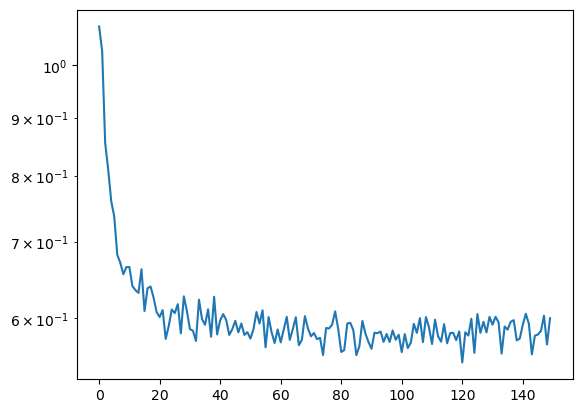

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:08,  1.12it/s]

 20%|██        | 2/10 [00:01<00:07,  1.12it/s]

 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

 40%|████      | 4/10 [00:03<00:06,  1.02s/it]

 50%|█████     | 5/10 [00:04<00:04,  1.02it/s]

 60%|██████    | 6/10 [00:05<00:03,  1.05it/s]

 70%|███████   | 7/10 [00:06<00:02,  1.08it/s]

 80%|████████  | 8/10 [00:07<00:01,  1.09it/s]

 90%|█████████ | 9/10 [00:08<00:00,  1.09it/s]

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

Test Loss: 0.5656


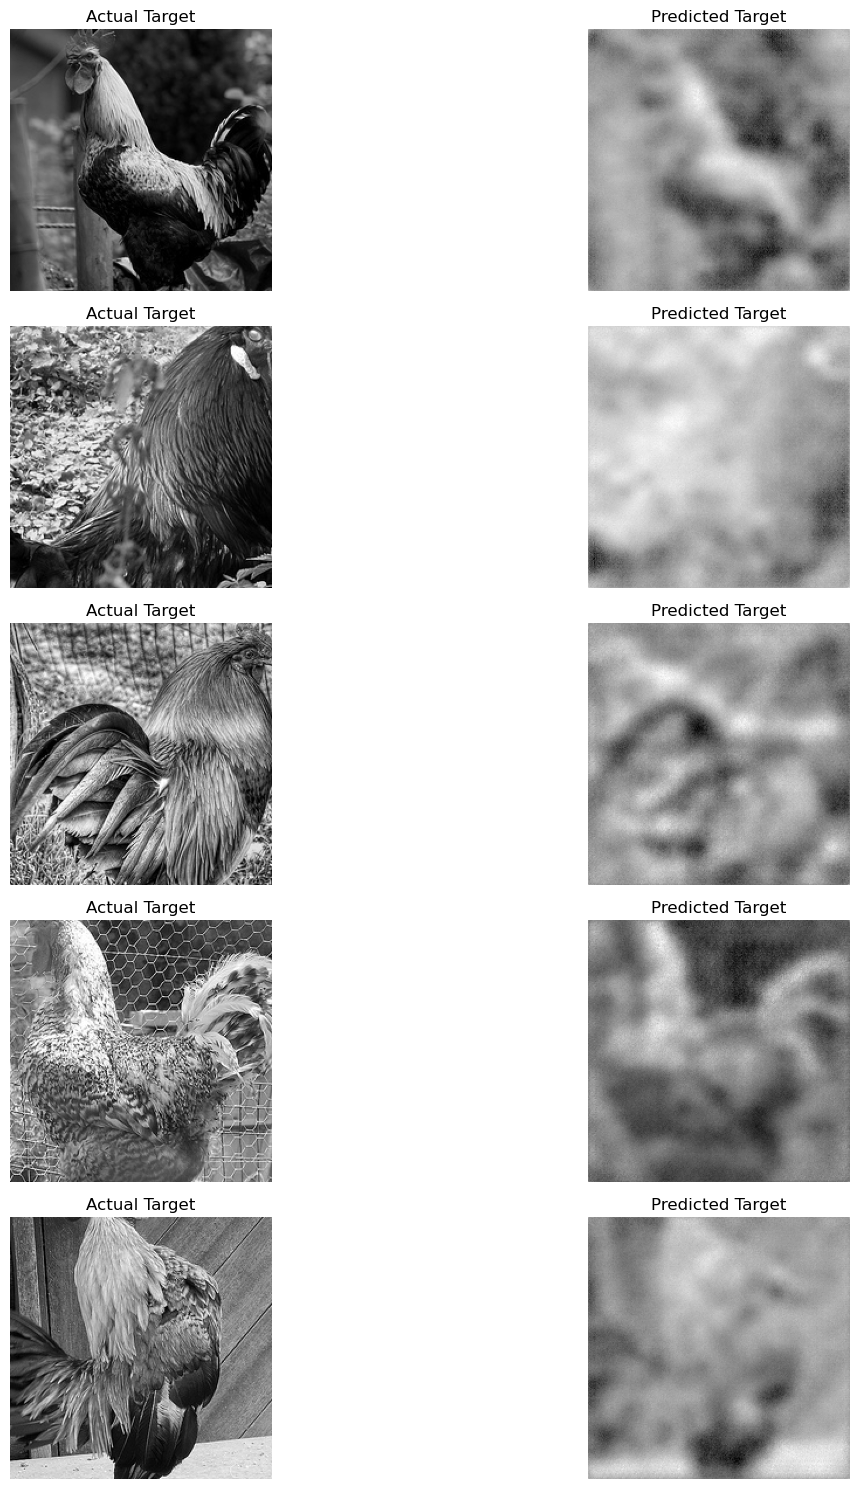

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-18.0894) tensor(4.2560)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))